SAI SUBHASH KOTARU

sk12154

In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [5]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("pantelism/cats-vs-dogs")

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [80]:
num_classes = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 10

In [7]:

from sklearn.model_selection import train_test_split


images = [item['image'] for item in dataset['train']]
labels = [item['label'] for item in dataset['train']]


train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

print(f"Train images: {len(train_images)}")
print(f"Test images: {len(test_images)}")


Train images: 3200
Test images: 800


In [9]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally with a 50% chance
    transforms.Lambda(lambda x: np.array(x) / 255.0),
    transforms.ToPILImage(),
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),      # Randomly rotate the image by up to 30 degrees  # Crop the image to 224x224 after resizing it randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random brightness, contrast, etc.
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.cpu()), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

images = [data_augmentation_transforms(img) for img in train_images]
train_images_tensor = torch.stack(images)
train_labels = torch.tensor(train_labels)

train_dataset = TensorDataset(train_images_tensor, train_labels)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


In [81]:
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
        self.layer2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.layer3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.layer4 = nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = None
        self.fc2 = nn.Linear(in_features=512,out_features=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.maxpool(F.relu(self.layer1(x)))
        out = self.maxpool(F.relu(self.layer2(out)))
        out = self.maxpool(F.relu(self.layer3(out)))
        out = self.maxpool(F.relu(self.layer4(out)))

        out = out.reshape(out.size(0), -1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(in_features=out.shape[1], out_features=512).to(x.device)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out


In [84]:
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=0.002)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
losses = []
for epoch in range(num_epochs):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device).unsqueeze(1).float()
    # print(i)
    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00


In [17]:
from captum.attr import IntegratedGradients, visualization as viz
from captum.attr import LayerGradCam, LayerAttribution

 **Integrated Gradients** is a path-based method that computes the integral of gradients as the input transitions from a baseline (e.g., a black image) to the actual input. It attributes importance by comparing how much each pixel affects the output along this path

torch.Size([3, 150, 150])
torch.Size([3, 150, 150])
0


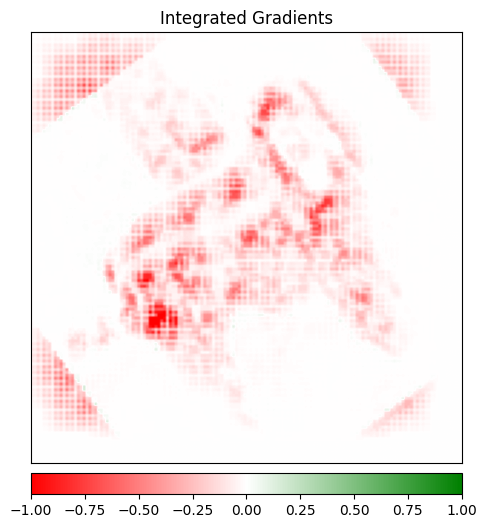

In [50]:

input_image = (train_images_tensor[0][:3,:,:]).to(device)
ig = IntegratedGradients(model)

# Define the baseline (black image)
baseline = torch.zeros_like(input_image).to(device)

target=(model(input_image.unsqueeze(0).to(device)) > 0.5).int().item()

# Compute attributions using Integrated Gradients
attributions_ig = ig.attribute(input_image.unsqueeze(0), baseline.unsqueeze(0), target = target, n_steps=200)

# Visualize attributions
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                             method="heat_map",
                             sign="all",
                             show_colorbar=True,
                             title="Integrated Gradients")




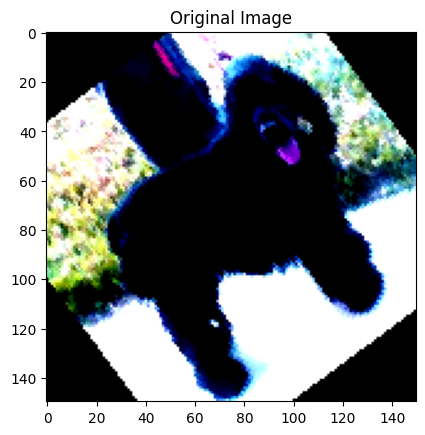

In [78]:
import matplotlib.pyplot as plt
import numpy as np
image_to_show = train_images_tensor[0].cpu().numpy()

image_to_show = np.transpose(image_to_show, (1, 2, 0))

image_to_show = np.clip(image_to_show, 0, 1)

plt.imshow(image_to_show)
plt.title("Original Image")
plt.show()

**Grad-CAM (Gradient-weighted Class Activation Mapping)** is a technique for visualizing which parts of an image a convolutional neural network (CNN) focuses on when making a prediction. It leverages the gradients flowing into the last convolutional layer to create a coarse localization map highlighting important regions in the image

torch.Size([3, 150, 150])
torch.Size([3, 150, 150])


/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


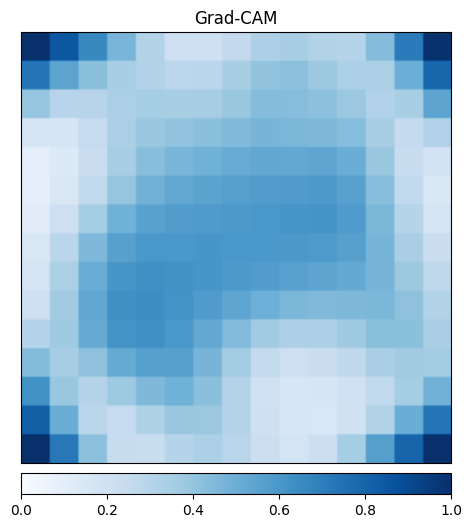

In [74]:
layer_gc = LayerGradCam(model, model.layer4)

input_image = input_image.squeeze(0)  # Convert shape [1, 3, 150, 150] to [3, 150, 150]
input_image = input_image.squeeze(0)

target=(model(input_image.unsqueeze(0).to(device)) > 0.5).int().item()
# Add back the batch dimension for processing by the model (shape: [1, 3, 150, 150])
input_image_for_model = input_image.unsqueeze(0)

attributions_gc = layer_gc.attribute(input_image_for_model, target=target)

# Upsample the attributions to the input image size
upsampled_gc = LayerAttribution.interpolate(attributions_gc, input_image.shape[1:])

# Ensure upsampled_gc is properly reshaped for visualization
upsampled_gc = upsampled_gc.squeeze().cpu().detach().numpy()

# If upsampled_gc is 2D, we add an additional axis to make it 3D for visualization
upsampled_gc = np.expand_dims(upsampled_gc, axis=2)

# Reshape original image from [3, 150, 150] to [150, 150, 3] for visualization
original_image = input_image.cpu().detach().numpy().transpose(1, 2, 0)

# Visualize attributions
_ = viz.visualize_image_attr(upsampled_gc,
                             original_image=original_image,
                             method="heat_map",
                             sign="absolute_value",
                             show_colorbar=True,
                             title="Grad-CAM")

In [ ]:
_ = viz.visualize_image_attr_multiple([upsampled_gc, attributions_ig],
                                      original_image=original_image,
                                      methods=["heat_map", "heat_map"],
                                      signs=["absolute_value", "absolute_value"],
                                      titles=["Grad-CAM", "Integrated Gradients"],
                                      show_colorbar=True)